# Obtain the wind effect on the ROMS-SODA output for the polygon area along the Dutch coast


Dewi has obtained two different sea-level budgets. 
- For the six tide gauge locations along the Dutch coast, for this the wind effect is obtained in a seperate notebook
- For a polygon area along the Dutch coast

In this notebook, the wind effect of both SODA reanalysis and ROMS output is obtained for the second case.

Dewi notebook: https://github.com/dlebars/SLBudget/blob/master/code/SeaLevelContrib.py

In [49]:
import xarray as xr
import pandas as pd
import xesmf as xe
import numpy as np

import regionmask
import copy


from sklearn.linear_model import LinearRegression as linr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

path = '/Users/iriskeizer/Documents/ROMS/data/wind effect'
path_fig = '/Users/iriskeizer/Documents/ROMS/figures/SODA/analysis/nov_2022/wind effect'

## Import data

In [50]:
# Import ROMS-GLORYS annual results
roms = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output/GLORYS/run1/NorthSea4_avg_run1_annual.nc')

In [51]:
# Import GLORYS reanalysis data
glorys = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS12V1/processed/glorys.nc')

In [52]:
# Import ERA5 and ERA-interim wind data
path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data'
era5 = xr.open_mfdataset(f'{path}/era5/raw/*.nc')
eraint = xr.open_mfdataset(f'{path}/era interim/raw/*.nc')

In [53]:
# Import AVISO data to regrid
aviso = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/CMEMS altimetry/l4_duacs_0.25deg/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1659969934244.nc')

## Data preparation

### GLORYS preparation

In [54]:
# Obtain annual averages
glorys = glorys.groupby('time.year').mean().rename({'year':'time'})

In [55]:
glorys

<xarray.Dataset>
Dimensions:    (time: 28, depth: 50, latitude: 313, longitude: 361)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 36.0 36.08 36.17 36.25 ... 61.83 61.92 62.0
  * longitude  (longitude) float32 -20.0 -19.92 -19.83 ... 9.833 9.917 10.0
  * time       (time) int64 1993 1994 1995 1996 1997 ... 2017 2018 2019 2020
Data variables:
    so         (time, depth, latitude, longitude) float32 36.47 ... -0.001526
    thetao     (time, depth, latitude, longitude) float32 18.99 19.0 ... 21.0
    uo         (time, depth, latitude, longitude) float32 -0.02253 ... 0.0
    vo         (time, depth, latitude, longitude) float32 -0.05315 ... 0.0
    zos        (time, latitude, longitude) float32 -0.3233 -0.3254 ... nan nan

In [56]:
# Drop unnecessary variables
glorys = glorys.drop(['so', 'thetao', 'uo', 'vo', 'depth'])
aviso = aviso.drop(['crs'])

In [57]:
glorys

<xarray.Dataset>
Dimensions:    (time: 28, latitude: 313, longitude: 361)
Coordinates:
  * latitude   (latitude) float32 36.0 36.08 36.17 36.25 ... 61.83 61.92 62.0
  * longitude  (longitude) float32 -20.0 -19.92 -19.83 ... 9.833 9.917 10.0
  * time       (time) int64 1993 1994 1995 1996 1997 ... 2017 2018 2019 2020
Data variables:
    zos        (time, latitude, longitude) float32 -0.3233 -0.3254 ... nan nan

### ROMS output preparation

#### Obtain dataset with time, latitude, longitude coordinates

In [58]:
def roms_to_latlon(data):
    '''
    Function to obtain a new dataset for the roms data where dimensions are latitude and longitude 
    data should be the ROMS output dataset 
    '''
    
    data_vars = dict(zeta=(["time", "latitude", "longitude"], data.zeta.values),)
        
    coords = dict(time=(["time"], data.time.values),
             latitude=(["latitude"], data.lat_rho.values[:,0]),
             longitude=(["longitude"], data.lon_rho.values[0]))
    
    return xr.Dataset(data_vars = data_vars, coords = coords)


roms = roms_to_latlon(roms)

### ERA preparation

In [59]:
# Remove data before 1993 and after 2020
era5 = era5.where((era5.time.dt.year < 2021) & (era5.time.dt.year > 2017), drop = True)
eraint = eraint.where((eraint.time.dt.year > 1992) & (eraint.time.dt.year < 2018), drop = True)

In [60]:
# Obtain annual averages
era5 = era5.groupby('time.year').mean('time').rename({'year' : 'time'})
eraint = eraint.groupby('time.year').mean('time').rename({'year' : 'time'})

In [61]:
# Obtain wind stress
era5 = era5.assign(u2 = era5.u10*(np.sqrt(era5.u10**2+era5.v10**2)), v2 = era5.v10*(np.sqrt(era5.u10**2+era5.v10**2)))
eraint = eraint.assign(u2 = eraint.u10*(np.sqrt(eraint.u10**2+eraint.v10**2)), v2 = eraint.v10*(np.sqrt(eraint.u10**2+eraint.v10**2)))

In [62]:
# Drop expver
era5 = era5.sel(expver=1).drop(['expver'])

In [63]:
# Drop wind speed
era5 = era5.drop(['u10', 'v10'])
eraint = eraint.drop(['u10', 'v10'])

In [64]:
# Combine data sets
windstress = xr.merge([era5, eraint])

### Regrid data onto AVISO grid

In [65]:
def regrid(input_data, roms_data, sl_var):
    '''
    Function to regrid datasets onto the AVISO 1/4° grid. 
    input_data should be the data that needs to be regridded
    aviso_data should be the data whereon the input_data will be regridded
    sl_var should be the name for sea level variable in the input_data 
    '''
    
    # Sort coordinates in increasing order
    input_data = input_data.sortby(['latitude', 'longitude'])
    
    # Transpose dimensions
    input_data = input_data.transpose('time', 'latitude', 'longitude')
    
    # Make arrays C_CONTIGUOUS
    roms_data = roms_data.astype(dtype = 'float32', order = 'C')
    input_data[sl_var] = input_data[sl_var].astype(dtype = 'float32', order = 'C')
    
    # Add mask
    input_data['mask'] = xr.where(~np.isnan(input_data[sl_var].isel(time=0)), 1, 0)
    roms_data['mask'] = xr.where(~np.isnan(roms_data.adt.isel(time=0)), 1, 0)
    
    # Build regridder
    regridder = xe.Regridder(input_data, roms_data, "bilinear", extrap_method= 'nearest_s2d')
    
    # Apply to data
    regridded_data = regridder(input_data)
    
    # Drop mask
    regridded_data = regridded_data.drop(['mask'])
    
    return regridded_data

In [66]:
glorys = regrid(glorys, aviso, 'zos')

In [67]:
roms = regrid(roms, aviso, 'zeta')

### Select polygon data

In [68]:
def obtain_polygon_region_data(data, var):
    '''
    Function to obtain a new dataset containing the data averaged over polygon areas
    
    
    '''
    
    df = pd.DataFrame(index=pd.Series(data.time.values, name="time"))
    
    
    location = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
    
    region = regionmask.Regions([location], names=['reg'], abbrevs=['reg'])
    
    # Define the mask and change its value from 0 to 1
    mask_alti = region.mask_3D(data.longitude, data.latitude)
    
    data_m = data.where(mask_alti)
    
    
    # Calculate the weighted regional average
    # !!! Only works with regular grids
    weights = np.cos(np.deg2rad(data.latitude))
    region_average = data.weighted(mask_alti * weights).mean(dim=('latitude', 'longitude'))
    
    if len(var) == 1:
        var, = var
        df['Average'] = region_average[var] - region_average[var][0]
    else:
        for v in var:
            df[f'Average {v}'] = region_average[v] - region_average[v][0]
    
    return df 

In [69]:
# Select polygon data for sea level
glorys = obtain_polygon_region_data(glorys, ['zos'])
roms = obtain_polygon_region_data(roms, ['zeta'])

In [70]:
# Select polygon data for wind stress
windstress = obtain_polygon_region_data(windstress, ['u2', 'v2'])


In [71]:
glorys.to_csv(f'{path}/sealevel_glorys_poly.csv')
roms.to_csv(f'{path}/sealevel_roms_poly.csv')

## Perform regression

In [75]:
def regression(sea_data, wind_data, name):
    """
    Function to perform the regression with sea-level and wind-stress data to obtain the wind effect on 
    sea level along the Dutch coast.
    
    """
    
    # Obtain trend timeseries to add to dataframe later
    trend = wind_data.index - wind_data.index[0]
    
    
    # Create lists containing names of regression terms
    regg_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$', 'trend']
    wind_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    
    
    # Create dataframe for y 
    y = sea_data
    
    # Create dataframe for x
    x = pd.DataFrame(data={'time': wind_data.index,
                            '$U \sqrt{u^2+v^2}$': wind_data['Average u2'],
                            '$V \sqrt{u^2+v^2}$': wind_data['Average v2'],
                            'trend': trend,})
        
    x = x.set_index('time')
        
    # Define regression
    regression_ = linr()
        
        
    # Interpolate to remove nan values
    x = x.interpolate(axis=0)
    y = y.interpolate(axis=0)
        
        
    # Standardize x
    scaler = StandardScaler()
    x = copy.deepcopy(x)
    x.iloc[:,:] = scaler.fit_transform(x)
        
        
    # Create copy such that regression result can be obtained for full timeseries
    x_timeseries = copy.deepcopy(x)
        
        
    # Create dataframes of equal time span
    y = y[y.index.isin(x.index)]
    x = x[x.index.isin(y.index)]
        
        
    # Fit the regression model and add results to lists
    fit = regression_.fit(x,y)
    score = regression_.score(x,y) # R^2 for the whole regression including the trend 
    intercept = regression_.intercept_
    coefs = regression_.coef_.T
    
    
    # Calculate rmse
    yhat = regression_.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse
    rmse = np.sqrt(mse)
        
        
    # Obtain dataframe containing timeseries resulting from regression
    df = pd.DataFrame(data=dict(time=x_timeseries.index))
    df = df.set_index('time')
    
    
    for i, reg in enumerate(regg_names):
        df[reg] = coefs[i] * x_timeseries[reg]
            
    df['total'] = df.sum(axis=1)
    df['wind total'] = df[wind_names].sum(axis=1)

        
    # Calculate R^2 values
    R2_total = score # R^2 for the whole regression including the trend
    R2_wind = R2_var(df, y, 'wind total', regression_)
    R2_u2 = R2_var(df, y, '$U \sqrt{u^2+v^2}$', regression_)
    R2_v2 = R2_var(df, y, '$V \sqrt{u^2+v^2}$', regression_)
                

    
    
    # Save dataframe
    df.to_csv(f'{path}/timeseries_{name}_poly.csv')
    
    
    
    # Create dataframe of coefficients
    
    
    results_df = pd.DataFrame(data={'Coefficient': ['R$^2$', 'R$^2_{wind}$', 'R$^2_{U \sqrt{u^2+v^2}}$', 'R$^2_{V \sqrt{u^2+v^2}}$', 'RMSE', 'constant', 'coef$_{U \sqrt{u^2+v^2}}$', 'coef$_{V \sqrt{u^2+v^2}}$', 'coef$_{trend}$']}).set_index('Coefficient')
    
    results_df['Result'] = [R2_total, R2_wind, R2_u2, R2_v2, rmse, intercept[0], coefs[0][0], coefs[1][0], coefs[2][0]]
    
    
    
    # Save dataframe
    results_df.to_csv(f'{path}/results_{name}_poly.csv')
    
    
    return(results_df, df)


    
    
def R2_var(df, y, var, regression_):
    """
    Function to obtain R-squared for a specific variable
    
    For var choose  ['wind total', '$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    """
    
    x = pd.DataFrame(data={'time': df.index.values, 
                                var : df[var].values})
    x = x.set_index('time')
    x = x[x.index.isin(y.index)]
    
    fit = regression_.fit(x, y)
    score = regression_.score(x,y)
    
    return score


In [76]:
results_glorys, timeseries_glorys = regression(glorys, windstress, 'glorys')

In [77]:
results_roms, timeseries_roms = regression(roms, windstress, 'roms')

In [78]:
results_glorys

,Result
Coefficient,
R$^2$,0.447896
R$^2_{wind}$,0.396558
R$^2_{U \sqrt{u^2+v^2}}$,0.399178
R$^2_{V \sqrt{u^2+v^2}}$,0.139535
RMSE,0.012633
constant,0.003460
coef$_{U \sqrt{u^2+v^2}}$,0.010931
coef$_{V \sqrt{u^2+v^2}}$,0.000475
coef$_{trend}$,-0.003890


In [79]:
results_roms

,Result
Coefficient,
R$^2$,0.506685
R$^2_{wind}$,0.454613
R$^2_{U \sqrt{u^2+v^2}}$,0.450997
R$^2_{V \sqrt{u^2+v^2}}$,0.134970
RMSE,0.017022
constant,-0.031510
coef$_{U \sqrt{u^2+v^2}}$,0.017447
coef$_{V \sqrt{u^2+v^2}}$,-0.000690
coef$_{trend}$,-0.005570


## Plot results

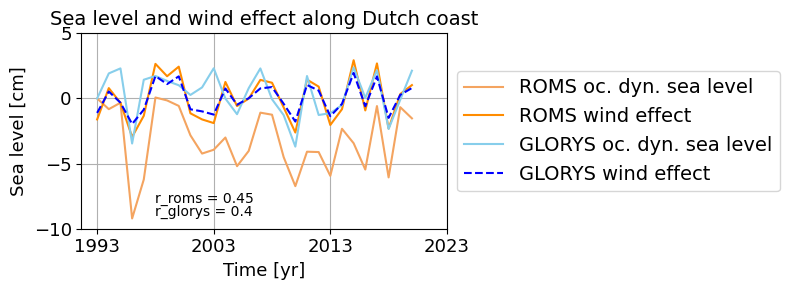

In [80]:
plt.figure(figsize = (8,3))
     
plt.plot(roms.index.values, roms['Average'].values*100, color='sandybrown')
plt.plot(timeseries_roms.index.values, timeseries_roms['wind total'].values*100, color='darkorange')
plt.plot(glorys.index.values, glorys['Average'].values*100, color='skyblue')
plt.plot(timeseries_glorys.index.values, timeseries_glorys['wind total'].values*100, color='blue', linestyle='--')
       
    
plt.xlabel('Time [yr]', fontsize = 13)
plt.ylabel('Sea level [cm]', fontsize = 13)
plt.title(f'Sea level and wind effect along Dutch coast', fontsize = 14)
plt.xticks(range(1993, 2024, 10), fontsize = 13)
plt.yticks(range(-10, 6, 5), fontsize = 13)
plt.yticks(fontsize = 13)
plt.grid()

labels=['ROMS oc. dyn. sea level','ROMS wind effect', 'GLORYS oc. dyn. sea level','GLORYS wind effect']
plt.legend(labels = labels, fontsize = 14, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.text(1998, -8, 'r_roms = ' + str(round(results_roms['Result']['R$^2_{wind}$'],2)))
plt.text(1998, -9, 'r_glorys = ' + str(round(results_glorys['Result']['R$^2_{wind}$'],2)))

plt.tight_layout()
    
plt.savefig(f'{path_fig}/sealevel_windeffect_dutchcoast_poly', bbox_inches="tight")

Again, the wind effect is exactly the same using GLORYS reanalysis and ROMS output data